In [165]:
import json
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

from os import listdir
from os.path import isfile, join

In [2]:
report = json.load(open('data/report-1.json', 'r'))

## Extract the most commons file extions
#### Due to then nature of _ransomwares_, most files are encrypted using a stadard extension, easily noticed.

In [3]:
extensions: dict = {}
for dropped_file in report.get('dropped', []):
    ext : str = dropped_file['name'].split('.')[-1] 
    if ext not in extensions.keys():
        extensions[ext] = 0
    extensions[ext]+=1

In [4]:
extensions

{'ecc': 4867, 'txt': 2, 'html': 1, 'dat': 1, 'lnk': 1, 'bmp': 1, 'exe': 1}

## Behaviorial Analyses focused on file Manipulation
### Ransomwares in the most need to make system calls to load and encrypt files resulting in a combination of multiple stages:
    1. Downloading encryption DLLs
    2. Acessing sever url to notify some status
    3. Loading files to memory
    4. Encrypting them
    5. Rewriting file back in the disk, usually with a different extension
    6. In favor of a complete encryption, multiple major paths-root paths of the system that usually common applications don't access simultaneosly are accessed by the ransonware.

In [68]:
def handle_most_common_extension(extension_dict: dict) -> (str, int):
    ext = ('', 0)
    if len(extensions) > 0:
        ext = sorted(extension_dict.items(), key=lambda item: item[1])[-1]
    return ext

In [94]:
def handle_moved_files(files) -> ((str, int), (str,int), bool):
    old_extensions: dict = {}
    new_extensions : dict = {}
    same_path_count: int = 0
    change_extension_count = 0
    for file in files:
        org : str = file[0]
        dest: str = file[1]
            
        org_ext = org.split('.')[-1]
        dest_ext = dest.split('.')[-1]
        
        same_path = (org.rindex('\\') if '\\' in org else org)  == (dest.rindex('\\') if '\\' in dest else dest)
        same_path_count = (same_path_count + 1) if  same_path else same_path_count
        
        if (org[0:-(len(org_ext))] != dest[0: -(len(dest_ext))]) and (org[0:-(len(org_ext))] != dest[0: -(len(dest_ext) + len(org_ext))]) and  (org[0:-(len(org_ext))] != dest[0: -(len(dest_ext) + len(org_ext) +1)]):
            change_extension_count +=1

        if org_ext not in old_extensions.keys():
            old_extensions[org_ext] = 0
        old_extensions[org_ext]+=1 

        if dest_ext not in new_extensions.keys():
            new_extensions[dest_ext] = 0
        new_extensions[dest_ext]+=1
    
    print('Original Extensions: ', old_extensions)
    print('Destination Extensions: ', new_extensions)
    print('Changed path as well: ', change_extension_count)
    
    max_new_extension =  handle_most_common_extension(new_extensions)
    
    return handle_most_common_extension(old_extensions), max_new_extension, change_extension_count < max_new_extension[1]*0.05

In [47]:
def handle_files(summary):
    features = {}
     # File Analyses
    files_types =['opened', 'read', 'created', 'recreated', 'moved', 'written']
    for file_type in files_types:
        param = 'file_'+ file_type
        files = summary.get(param)
        if files:
            features[param]= len(files)

            if file_type == 'moved':
                org_extesion, dest_extension, only_ext_changed = handle_moved_files(files)
                features['commonest_orig_extension'] = org_extesion[0]
                features['commonest_orig_extension_count'] =  org_extesion[1]
                features['commonest_moved_extension'] = dest_extension[0]
                features['commonest_moved_extension_count'] =  dest_extension[1]
                features['only_extension_changed'] = only_ext_changed
    return features

In [92]:
def handle_directory(summary):
    # Directory Analyses
    features = {}
    directories = summary.get('directory_enumerated')
    if directories:
        major_paths = set(list(map(lambda dir: dir.split(':')[1].split('\\')[1], directories)))
        print('Major paths: ', major_paths)
        major_paths = len(major_paths)
        features['paths_enumerated'] = len(directories)
        features['major_paths_enumerated'] = major_paths
        features['enumerate_more_than_3_major_paths'] = major_paths > 3
    return features

In [88]:
def handle_commands(summary):
    features = {}
    commands = summary.get('command_line', [])
    remove_backup = len(list(filter(lambda cmd: 'shadows' in cmd or '>> NULL' in cmd, commands)))
    features['deleted_shadow'] = remove_backup > 0
    return features

In [84]:
def analyze(summary):
    features={
    'dll_downloaded': 0,
    'crypto_dll_downloaded': False,
    'file_recreated': 0,
    'file_opened': 0,
    'file_created': 0,
    'file_written': 0,
    'file_renamed': 0,
    'file_recreated': 0,
    'deleted_shadow': False,
    'only_extension_changed': False,
    'commonest_moved_extension': '',
    'commonest_moved_extension_count': 0,
    'commonest_orig_extension': '',
    'commonest_orig_extension_count': '',
    'enumerate_more_than_3_major_paths': False,
    'major_paths_enumerated': 0,
    'paths_enumerated': 0
    }
    
    if summary:
        features.update(handle_files(summary))
        features.update(handle_directory(summary))
        features.update(handle_commands(summary))
    return features

In [96]:
def process_json(json_path):
    report = json.load(open(json_path, 'r'))
    return report.get('behavior', {}).get('summary', {})

In [166]:
def run():
    dataset = []
    for file in [f for f in listdir('data/') if isfile(join('data/', f))]:
        json_path = 'data/'+str(file)
        report = process_json(json_path)
        features = analyze(report)
        print(features)
        dataset.append(features)
    with open('result.json', 'w+') as f:
        f.write(json.dumps(dataset))

In [167]:
run()

Major paths:  {'MSDOS.SYS', 'WINDOWS', 'IO.SYS', 'Documents and Settings', 'Program Files'}
{'dll_downloaded': 0, 'crypto_dll_downloaded': False, 'file_recreated': 13, 'file_opened': 56, 'file_created': 0, 'file_written': 19, 'file_renamed': 0, 'deleted_shadow': False, 'only_extension_changed': False, 'commonest_moved_extension': '', 'commonest_moved_extension_count': 0, 'commonest_orig_extension': '', 'commonest_orig_extension_count': '', 'enumerate_more_than_3_major_paths': True, 'major_paths_enumerated': 5, 'paths_enumerated': 33, 'file_read': 32}
Major paths:  {'Windows', 'Users'}
{'dll_downloaded': 0, 'crypto_dll_downloaded': False, 'file_recreated': 1, 'file_opened': 25, 'file_created': 1, 'file_written': 3, 'file_renamed': 0, 'deleted_shadow': False, 'only_extension_changed': False, 'commonest_moved_extension': '', 'commonest_moved_extension_count': 0, 'commonest_orig_extension': '', 'commonest_orig_extension_count': '', 'enumerate_more_than_3_major_paths': False, 'major_paths_e

In [168]:
dataset = json.load(open('result.json', 'r'))

In [169]:
df = pd.DataFrame(dataset)
df.fillna(0, inplace = True)
df['deleted_shadow'] = df['deleted_shadow'].astype(str)
df['crypto_dll_downloaded'] = df['crypto_dll_downloaded'].astype(str)
df['only_extension_changed'] = df['only_extension_changed'].astype(str)
df['enumerate_more_than_3_major_paths'] = df['enumerate_more_than_3_major_paths'].astype(str)
df

,dll_downloaded,crypto_dll_downloaded,file_recreated,file_opened,file_created,file_written,file_renamed,deleted_shadow,only_extension_changed,commonest_moved_extension,commonest_moved_extension_count,commonest_orig_extension,commonest_orig_extension_count,enumerate_more_than_3_major_paths,major_paths_enumerated,paths_enumerated,file_read,file_moved
0,0,False,13,56,0,19,0,False,False,,0,,,True,5,33,32.0,0.0
1,0,False,1,25,1,3,0,False,False,,0,,,False,2,11,16.0,0.0
2,0,False,0,0,0,0,0,False,False,,0,,,False,0,0,0.0,0.0
3,0,False,10,316,0,19,0,False,False,,0,,,False,2,72,24.0,0.0
4,0,False,4,24,0,8,0,False,False,,0,,,False,1,31,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,0,False,4,0,0,0,0,False,False,,0,,,False,0,0,0.0,0.0
222,0,False,1,5,0,3,0,False,False,,0,,,False,0,0,0.0,0.0
223,0,False,0,1,0,0,0,False,False,,0,,,False,1,6,1.0,0.0
224,0,False,0,4,0,0,0,False,False,,0,,,False,0,0,3.0,0.0


<ipython-input-195-0a8e84bb0892>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax=ax, bins=50, bottom=0.1)


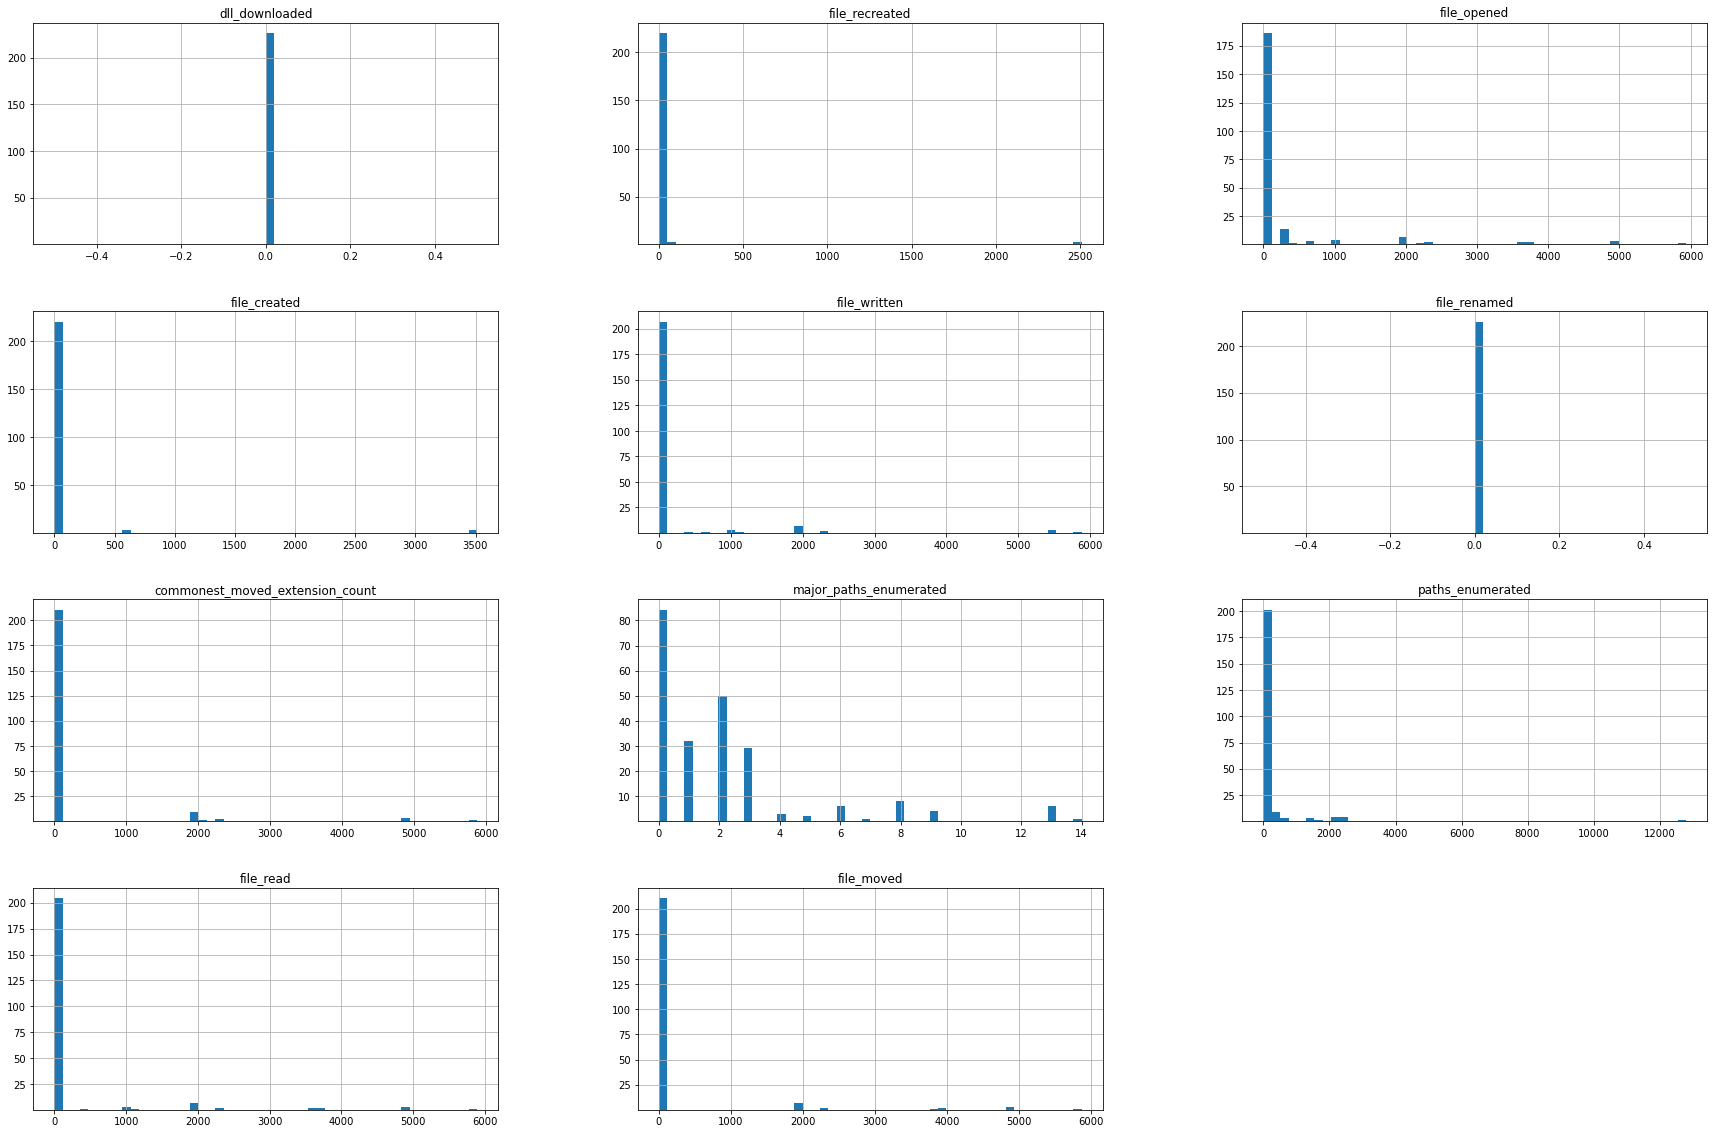

In [195]:
%matplotlib inline

fig, ax = plt.subplots(figsize = (30,20))
df.hist(ax=ax, bins=50, bottom=0.1)
ax.set_yscale('log')

In [154]:
df.corr()

,dll_downloaded,file_recreated,file_opened,file_created,file_written,file_renamed,commonest_moved_extension_count,major_paths_enumerated,paths_enumerated,file_read,file_moved
dll_downloaded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
file_recreated,NaN,1.000000,0.465399,0.730434,0.560681,NaN,0.529213,0.456225,0.096966,0.431448,0.529031
file_opened,NaN,0.465399,1.000000,0.439771,0.714806,NaN,0.690854,0.702976,0.618276,0.987413,0.690849
file_created,NaN,0.730434,0.439771,1.000000,0.672371,NaN,0.636476,0.341073,0.075580,0.455690,0.636227
file_written,NaN,0.560681,0.714806,0.672371,1.000000,NaN,0.984646,0.658239,0.213958,0.709613,0.984630
file_renamed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
commonest_moved_extension_count,NaN,0.529213,0.690854,0.636476,0.984646,NaN,1.000000,0.619396,0.157949,0.705738,1.000000
major_paths_enumerated,NaN,0.456225,0.702976,0.341073,0.658239,NaN,0.619396,1.000000,0.685227,0.667245,0.619329
paths_enumerated,NaN,0.096966,0.618276,0.075580,0.213958,NaN,0.157949,0.685227,1.000000,0.586295,0.157935
file_read,NaN,0.431448,0.987413,0.455690,0.709613,NaN,0.705738,0.667245,0.586295,1.000000,0.705735


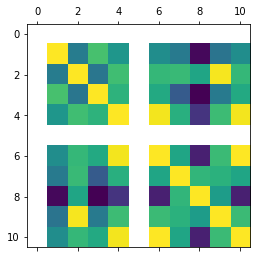

In [157]:
plt.matshow(df.corr())
plt.show()

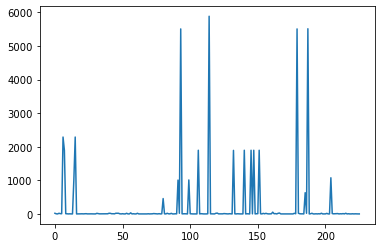

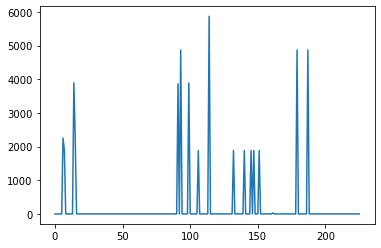

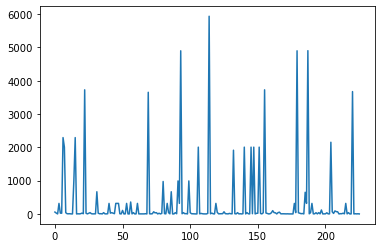

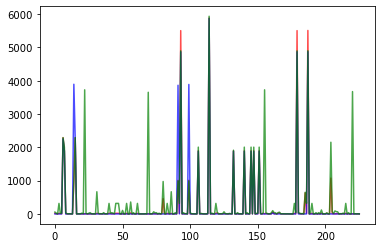

In [185]:
plt.plot(df['file_written'])
plt.show()
plt.plot(df['file_moved'])
plt.show()
plt.plot(df['file_opened'])
plt.show()
plt.plot(df['file_written'], color='r', alpha=0.7)
plt.plot(df['file_moved'], color='b', alpha=0.7)
plt.plot(df['file_opened'], color='g', alpha=0.7)
plt.show()